<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/stacking/4.model_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np

In [2]:
# PEP 8
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

# Import module files

In [3]:
%%capture
git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/main/'

files = [
    'path_manager.py',
    'model.py',
    'sklearn_utils.py'
]


def download_files(dict_):
    for file, url in dict_.items():
        !wget -O {file} {url} {file}


download_files(
    {
        file: git_download_path + file
        for file in files
    }
)

pep8(_ih)

In [4]:
import importlib
import path_manager
import sklearn_utils
import model

def reload_all(modules):
    for module in modules:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        model,
        sklearn_utils
    ]
)

from path_manager import PathManager
from sklearn_utils import print_model_cv_scores
from sklearn_utils import plot_cv_results
from sklearn_utils import dict_subset

# Setup paths

In [10]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

COMPETITION_PATH = gdrive_path + 'ML/Competitions/5.RestaurantRevenue/'
PREPROC_TRIAL = 4
MODELS_TRIAL = 'Stacking'

pep8(_ih)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



In [11]:
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)

pep8(_ih)

# Download models

In [12]:
models = manager.load_models(
    [
        # 'RF_final',
        # 'XGB_final',
        # 'Voting_final'
        # 'SVM_final',
        # 'ElasticNet_final'
        'Stacking reg'
    ]
)

In [13]:
models

{'Stacking reg': StackingRegressor(estimators=[('ElasticNet',
                                ElasticNet(alpha=0.05, l1_ratio=0.2,
                                           random_state=42)),
                               ('XGB',
                                GradientBoostingRegressor(max_features='sqrt',
                                                          n_estimators=3,
                                                          random_state=42,
                                                          subsample=0.5))],
                   final_estimator=RandomForestRegressor(max_depth=2,
                                                         n_estimators=4))}

# Download data

In [14]:
df_test = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'test_processed.csv'
    ),
    index_col=[0]
)

# subsample from train.csv for testing
df_test_sample = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'test_sample_processed.csv'
    ),
    index_col=[0]
)

df_trainval = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'trainval_sample_processed.csv'
    ),
    index_col=[0]
)

X_train_val = df_trainval.values[:, :-1]
Y_train_val = df_trainval.values[:, -1]

X_test_sample = df_test_sample.values[:, :-1]
Y_test_sample = df_test_sample.values[:, -1]

# Cross validation performance for final models

Model           Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
------------  ----------------------  ----------------  ------------------------  ------------------
Stacking reg               -0.208954         0.0113692                 -0.219685            0.102239


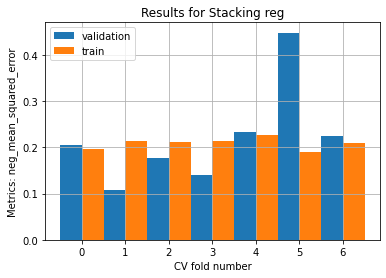

In [15]:
_ = plot_cv_results(
    models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=7,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

# Report test sample performance

In [16]:
final_model = models['Stacking reg']

final_model.fit(
    X_train_val,
    Y_train_val
)

StackingRegressor(estimators=[('ElasticNet',
                               ElasticNet(alpha=0.05, l1_ratio=0.2,
                                          random_state=42)),
                              ('XGB',
                               GradientBoostingRegressor(max_features='sqrt',
                                                         n_estimators=3,
                                                         random_state=42,
                                                         subsample=0.5))],
                  final_estimator=RandomForestRegressor(max_depth=2,
                                                        n_estimators=4))

In [17]:
from sklearn.metrics import mean_squared_error


test_sample_predictions = final_model.predict(X_test_sample)
test_result = mean_squared_error(
    np.exp(test_sample_predictions),
    np.exp(Y_test_sample)
)
print(test_result)

pep8(_ih)

4076209426703.8774



# Retraining on all available data

In [18]:
final_arr = np.vstack([X_train_val, X_test_sample])
final_target = np.hstack([Y_train_val, Y_test_sample])
final_arr.shape,  final_target.shape

((137, 82), (137,))

In [19]:
final_model.fit(
    final_arr,
    final_target
)

StackingRegressor(estimators=[('ElasticNet',
                               ElasticNet(alpha=0.05, l1_ratio=0.2,
                                          random_state=42)),
                              ('XGB',
                               GradientBoostingRegressor(max_features='sqrt',
                                                         n_estimators=3,
                                                         random_state=42,
                                                         subsample=0.5))],
                  final_estimator=RandomForestRegressor(max_depth=2,
                                                        n_estimators=4))

# Submission and saving final model

In [20]:
df_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,0.000000,0.461538,0.533333,0.222222,0.000000,0.111111,0.444444,0.333333,0.166667,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.181818,0.461538,0.533333,0.222222,0.142857,0.111111,0.444444,0.222222,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
# Remove target (that was artificially created during data processing pipeline)
submission_data = df_test.values[:, :-1]
submission_data.shape

(100000, 82)

In [22]:
final_predictions = np.exp(
    final_model.predict(submission_data)
)

In [23]:
df_submission = pd.DataFrame(final_predictions, columns=['Prediction'])
df_submission.index.rename('Id', inplace=True)
df_submission.head()

,Prediction
Id,
0,3.727823e+06
1,3.147309e+06
2,3.727823e+06
3,3.727823e+06
4,3.727823e+06


In [24]:
final_model_name = 'Stacking retrained'

submission_path = os.path.join(
    manager.models_trial_path,
    final_model_name,
    'submission.csv'
)

manager.save_models(
    {
        final_model_name: final_model
    }
)
df_submission.to_csv(submission_path)